# **Objective**
*   Predict Female's Life Expectancy using SDG indicators as the features
*   Perform Data preprocessing, exploratory data analysis, and building basic learning pipelines for random forest regression models  
*   Analyse the model parameters and interpret their significance in relation to the SDGs and their impact on Life Expectancy.




In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

openjdk-8-jdk-headless is already the newest version (8u422-b05-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
CUSTOM_FOLDER_NAME = "My Custom Folder"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/" + CUSTOM_FOLDER_NAME
DATASET_URL = "https://github.com/gtolomei/big-data-computing/raw/master/datasets/king-county-house-sales.csv.bz2"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/sdg2.csv"

RANDOM_SEED = 42 # for reproducibility

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
# /content/gdrive/MyDrive/kth/data intensive computing - group work/Task2 Project/dataset.csv
#/content/gdrive/MyDrive/data intensive computing/dataset.csv
GDRIVE_DIR = "/content/gdrive"
GDRIVE_DATASET_FILE = GDRIVE_DIR + "/MyDrive/data intensive computing/dataset.csv"
RANDOM_SEED = 42

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-5-5ba514b7d484>:2 

In [ ]:
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


In [ ]:
spark

# **1. Data Collection**
The dataset was collected from "World Development Indicators DataBank" with the following filters :

Period : 2014-2023

Countries : low income, lower middle income, high income and upper middle income

The following Series was selected from the dataset :

SDG 1: GNI per capita, PPP (current international $) (NY.GNP.PCAP.PP.CD)

SDG 2: Prevalence of undernourishment (% of population) (SN.ITK.DEFC.ZS)

SDG 3: Prevalence of HIV, total (% of population ages 15-49) (SH.DYN.AIDS.ZS

SDG 4: School enrollment, primary (% net) (SE.PRM.NENR)

SDG 5: Labor force participation rate, female (% of female population ages 15+) (national estimate) (SL.TLF.CACT.FE.NE.ZS)

SDG 6: People using at least basic drinking water services (% of population)

SDG 7: Access to electricity (% of population) (EG.ELC.ACCS.ZS)

SDG 8: Unemployment with basic education,female (% of total labor force with basic education) (SL.UEM.BASC.ZS)

SDG 11: Urban population (% of total population), Population living in slums (% of urban population) (EN.POP.SLUM.UR.ZS)

SDG 12: Population density (people per sq. km of land area) (EN.POP.DNST)

SDG 13: Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) (EN.GHG.CO2.PC.CE.AR5)

SDG 15: Forest area (% of land area) (AG.LND.FRST.ZS)

SDG 17: Military expenditure (% of GDP) (MS.MIL.XPND.GD.ZS)

Life expectancy at birth, female (years)

In [ ]:
sdg_df = spark.read.load(GDRIVE_DATASET_FILE,
                         format="csv",
                         sep=";",
                         inferSchema="true",
                         header="true"
                         )

# **2. Data Processing**
Considering that features with a large amount of missing values contribute little to the analysis, we drop features with over 35% of their values missing and columns that are not included within the Sustainable Development Goals (SDGs) indicators, such as "Time Code." The following features were dropped:

- Time Code
- Time
- Country Name
- Country Code
- Unemployment with basic education, female (% of female labor force with basic education)
- Labor force participation rate, female (% of female population ages 15+) (national estimate)
- Prevalence of HIV, female (% ages 15-24)
- Military expenditure (% of GDP)
- Prevalence of undernourishment (% of population)
- School enrollment, primary, private (% of total primary)

In [ ]:
print(f"The shape of the dataset is {sdg_df.count()} rows by {len(sdg_df.columns)} columns")

The shape of the dataset is 2165 rows by 18 columns


In [ ]:
sdg_df.printSchema()

root
 |-- Time: string (nullable = true)
 |-- Time Code: string (nullable = true)
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Population density (people per sq. km of land area) [EN.POP.DNST]: string (nullable = true)
 |-- Prevalence of undernourishment (% of population) [SN.ITK.DEFC.ZS]: string (nullable = true)
 |-- Prevalence of HIV, female (% ages 15-24) [SH.HIV.1524.FE.ZS]: string (nullable = true)
 |-- School enrollment, primary, private (% of total primary) [SE.PRM.PRIV.ZS]: string (nullable = true)
 |-- People using at least basic drinking water services (% of population) [SH.H2O.BASW.ZS]: string (nullable = true)
 |-- Labor force participation rate, female (% of female population ages 15+) (national estimate) [SL.TLF.CACT.FE.NE.ZS]: string (nullable = true)
 |-- Unemployment with basic education, female (% of female labor force with basic education) [SL.UEM.BASC.FE.ZS]: string (nullable = true)
 |-- Urban population (% of total 

In [ ]:
sdg_df.show(10,False)

+----+---------+------------+------------+-----------------------------------------------------------------+-----------------------------------------------------------------+------------------------------------------------------------+-------------------------------------------------------------------------+--------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+------------------------------------------------------------+-------------------------------------------------------------------------------------------------+---------------------------------------------+---------------------------------------------------+------------------------------------------------------------+-------------------------------------------------------------

**Rename the features to exclude the portion of the column name in square-brackets**

In [ ]:
column_names = [
    "Time",
    "Time Code",
    "Country Name",
    "Country Code",
    "Population density (people per sq km of land area)",
    "Prevalence of undernourishment (% of population)",
    "Prevalence of HIV, female (% ages 15-24)",
    "School enrollment, primary, private (% of total primary)",
    "People using at least basic drinking water services (% of population)",
    "Labor force participation rate, female (% of female population ages 15+) (national estimate)",
    "Unemployment with basic education, female (% of female labor force with basic education)",
    "Urban population (% of total population)",
    "Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)",
    "Forest area (% of land area)",
    "Military expenditure (% of GDP)",
    "Life expectancy at birth, female (years)",
    "GNI per capita, PPP (current international)",
    "Access to electricity (% of population)"
]
for i in range(len(sdg_df.columns)):
    sdg_df = sdg_df.withColumnRenamed(sdg_df.columns[i], column_names[i])


The dataset represents null values as ".." therefore this value was replaced with None to facilitate data preprocessing

In [ ]:
sdg_df =sdg_df.replace('..',None)

In [ ]:
# Show the result
sdg_df.show()

+----+---------+------------------+------------+--------------------------------------------------+------------------------------------------------+----------------------------------------+--------------------------------------------------------+---------------------------------------------------------------------+--------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------+----------------------------------------+--------------------------------------------------------------------------+----------------------------+-------------------------------+----------------------------------------+-------------------------------------------+---------------------------------------+
|Time|Time Code|      Country Name|Country Code|Population density (people per sq km of land area)|Prevalence of undernourishment (% of population)|Prevalence of HIV, female (% ages 15-24)|School enr

**Calculate the number of missing values ​​in each column and display them：**

In [ ]:
missing_values = sdg_df.select(
    [(sdg_df[col].isNull().cast("int")).alias(col) for col in sdg_df.columns]
).agg(*[sum(col).alias(col) for col in sdg_df.columns]).toPandas()
missing_values.T.rename(columns={0: 'Missing Values'}).sort_values(by='Missing Values', ascending=False)

,Missing Values
"Unemployment with basic education, female (% of female labor force with basic education)",1111
"Labor force participation rate, female (% of female population ages 15+) (national estimate)",1000
"Prevalence of HIV, female (% ages 15-24)",913
Military expenditure (% of GDP),817
Prevalence of undernourishment (% of population),811
"School enrollment, primary, private (% of total primary)",796
Forest area (% of land area),461
Population density (people per sq km of land area),445
Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita),347
People using at least basic drinking water services (% of population),322


**Remove the top six features with the most missing values:**

In [ ]:
sdg_df = sdg_df.drop('Time Code')\
              .drop('Time')\
              .drop('Country Name')\
              .drop('Country Code')\
              .drop('Unemployment with basic education, female (% of female labor force with basic education)')\
              .drop('Labor force participation rate, female (% of female population ages 15+) (national estimate)')\
              .drop('Prevalence of HIV, female (% ages 15-24)')\
              .drop('Military expenditure (% of GDP)')\
              .drop('Prevalence of undernourishment (% of population)')\
              .drop('School enrollment, primary, private (% of total primary)')

In [ ]:
sdg_df = sdg_df.na.drop()

**Check for duplicated records:**

In [ ]:
print(f"The total number of duplicated records is {sdg_df.count()-sdg_df.dropDuplicates().count()}")

The total number of duplicated records is 0


In [ ]:
print(f"The shape of the dataset is {sdg_df.count()} rows by {len(sdg_df.columns)} columns")

The shape of the dataset is 1428 rows by 8 columns


**Change the dataframe schema to be float:**

In [ ]:
for column in sdg_df.columns:
  sdg_df = sdg_df.withColumn(column, col(column).cast('float'))

In [ ]:
sdg_df.show(5, False)

+--------------------------------------------------+---------------------------------------------------------------------+----------------------------------------+--------------------------------------------------------------------------+----------------------------+----------------------------------------+-------------------------------------------+---------------------------------------+
|Population density (people per sq km of land area)|People using at least basic drinking water services (% of population)|Urban population (% of total population)|Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)|Forest area (% of land area)|Life expectancy at birth, female (years)|GNI per capita, PPP (current international)|Access to electricity (% of population)|
+--------------------------------------------------+---------------------------------------------------------------------+----------------------------------------+---------------------------------------------------

# **3.Exploratory Data Analysis (EDA)**
**Visualise and compute statistics of dataset.**

In [ ]:
sdg_df.describe().show()

+-------+--------------------------------------------------+---------------------------------------------------------------------+----------------------------------------+--------------------------------------------------------------------------+----------------------------+----------------------------------------+-------------------------------------------+---------------------------------------+
|summary|Population density (people per sq km of land area)|People using at least basic drinking water services (% of population)|Urban population (% of total population)|Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)|Forest area (% of land area)|Life expectancy at birth, female (years)|GNI per capita, PPP (current international)|Access to electricity (% of population)|
+-------+--------------------------------------------------+---------------------------------------------------------------------+----------------------------------------+---------------------------

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
sdg_pdf = sdg_df.toPandas()

In [ ]:
# Set some default plotting configuration using seaborn properties
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2,
                                "xtick.labelsize":14,
                                "ytick.labelsize":14,
                                "axes.labelsize": 16
                                })

# **Distribution histograms Plots**
Draw histograms for the SDG features in the data frame sdg_pdf to observe the data distribution of these features. The code first excludes the columns related to female life expectancy and generates histograms for the remaining columns. For the "population density (number of people per square kilometer)" column, we perform a logarithmic transformation to better show its distribution characteristics (otherwise its data span is too large). The remaining columns are directly plotted in histograms.

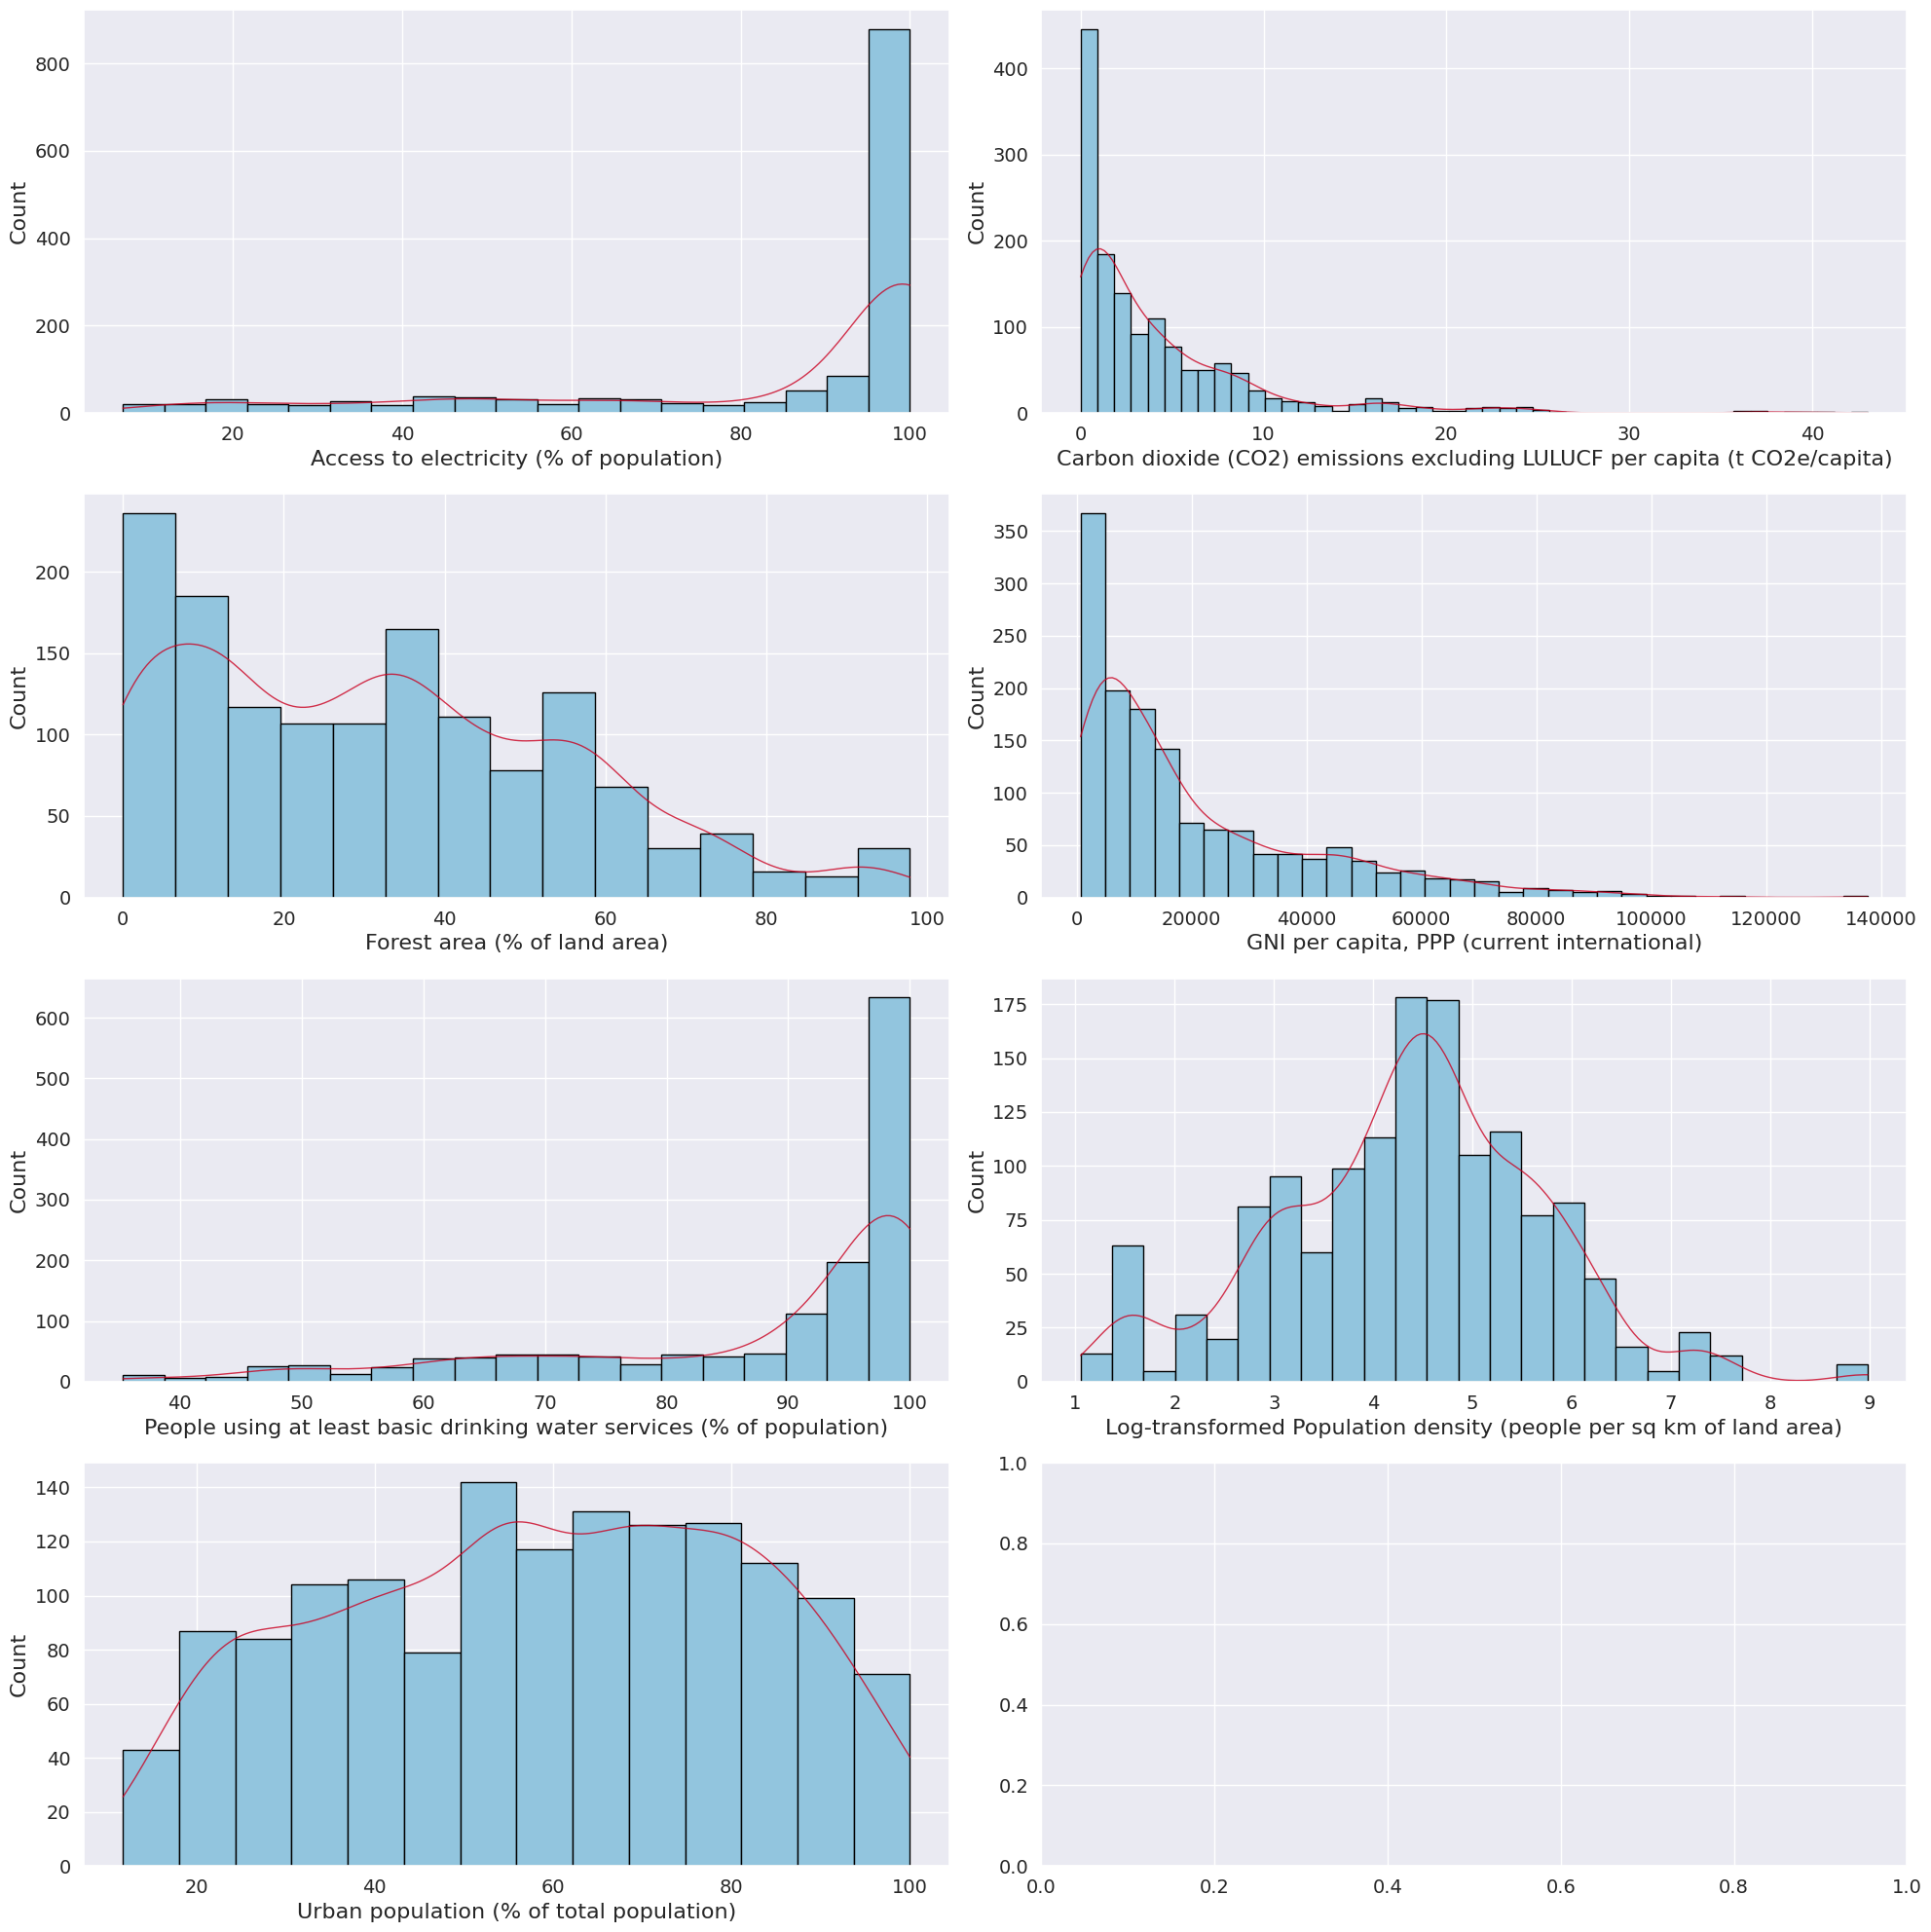

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.flatten()

col_to_plot = [col for col in sorted(sdg_pdf.columns[0:]) if col != "Life expectancy at birth, female (years)"]

for i, feature_name in enumerate(col_to_plot[:7]):
    if feature_name == "Population density (people per sq km of land area)":
        data = np.log1p(sdg_pdf[feature_name])
        ax = sns.histplot(data,
                          kde=True,
                          color="#ca0020",
                          line_kws={"linewidth": 1, "alpha": 0.8},
                          facecolor="#92c5de",
                          edgecolor="black",
                          ax=axes[i]
                         )
        ax.set_xlabel("Log-transformed Population density (people per sq km of land area)")  # 更改标签
    else:
        ax = sns.histplot(sdg_pdf[feature_name],
                          kde=True,
                          color="#ca0020",
                          line_kws={"linewidth": 1, "alpha": 0.8},
                          facecolor="#92c5de",
                          edgecolor="black",
                          ax=axes[i]
                         )

fig.tight_layout()

# **Correlation regression curve Plots**
Plot a scatter plot of the relationship between each independent variable and the target variable (“Female life expectancy at birth”) and show the correlation between them using a regression line.

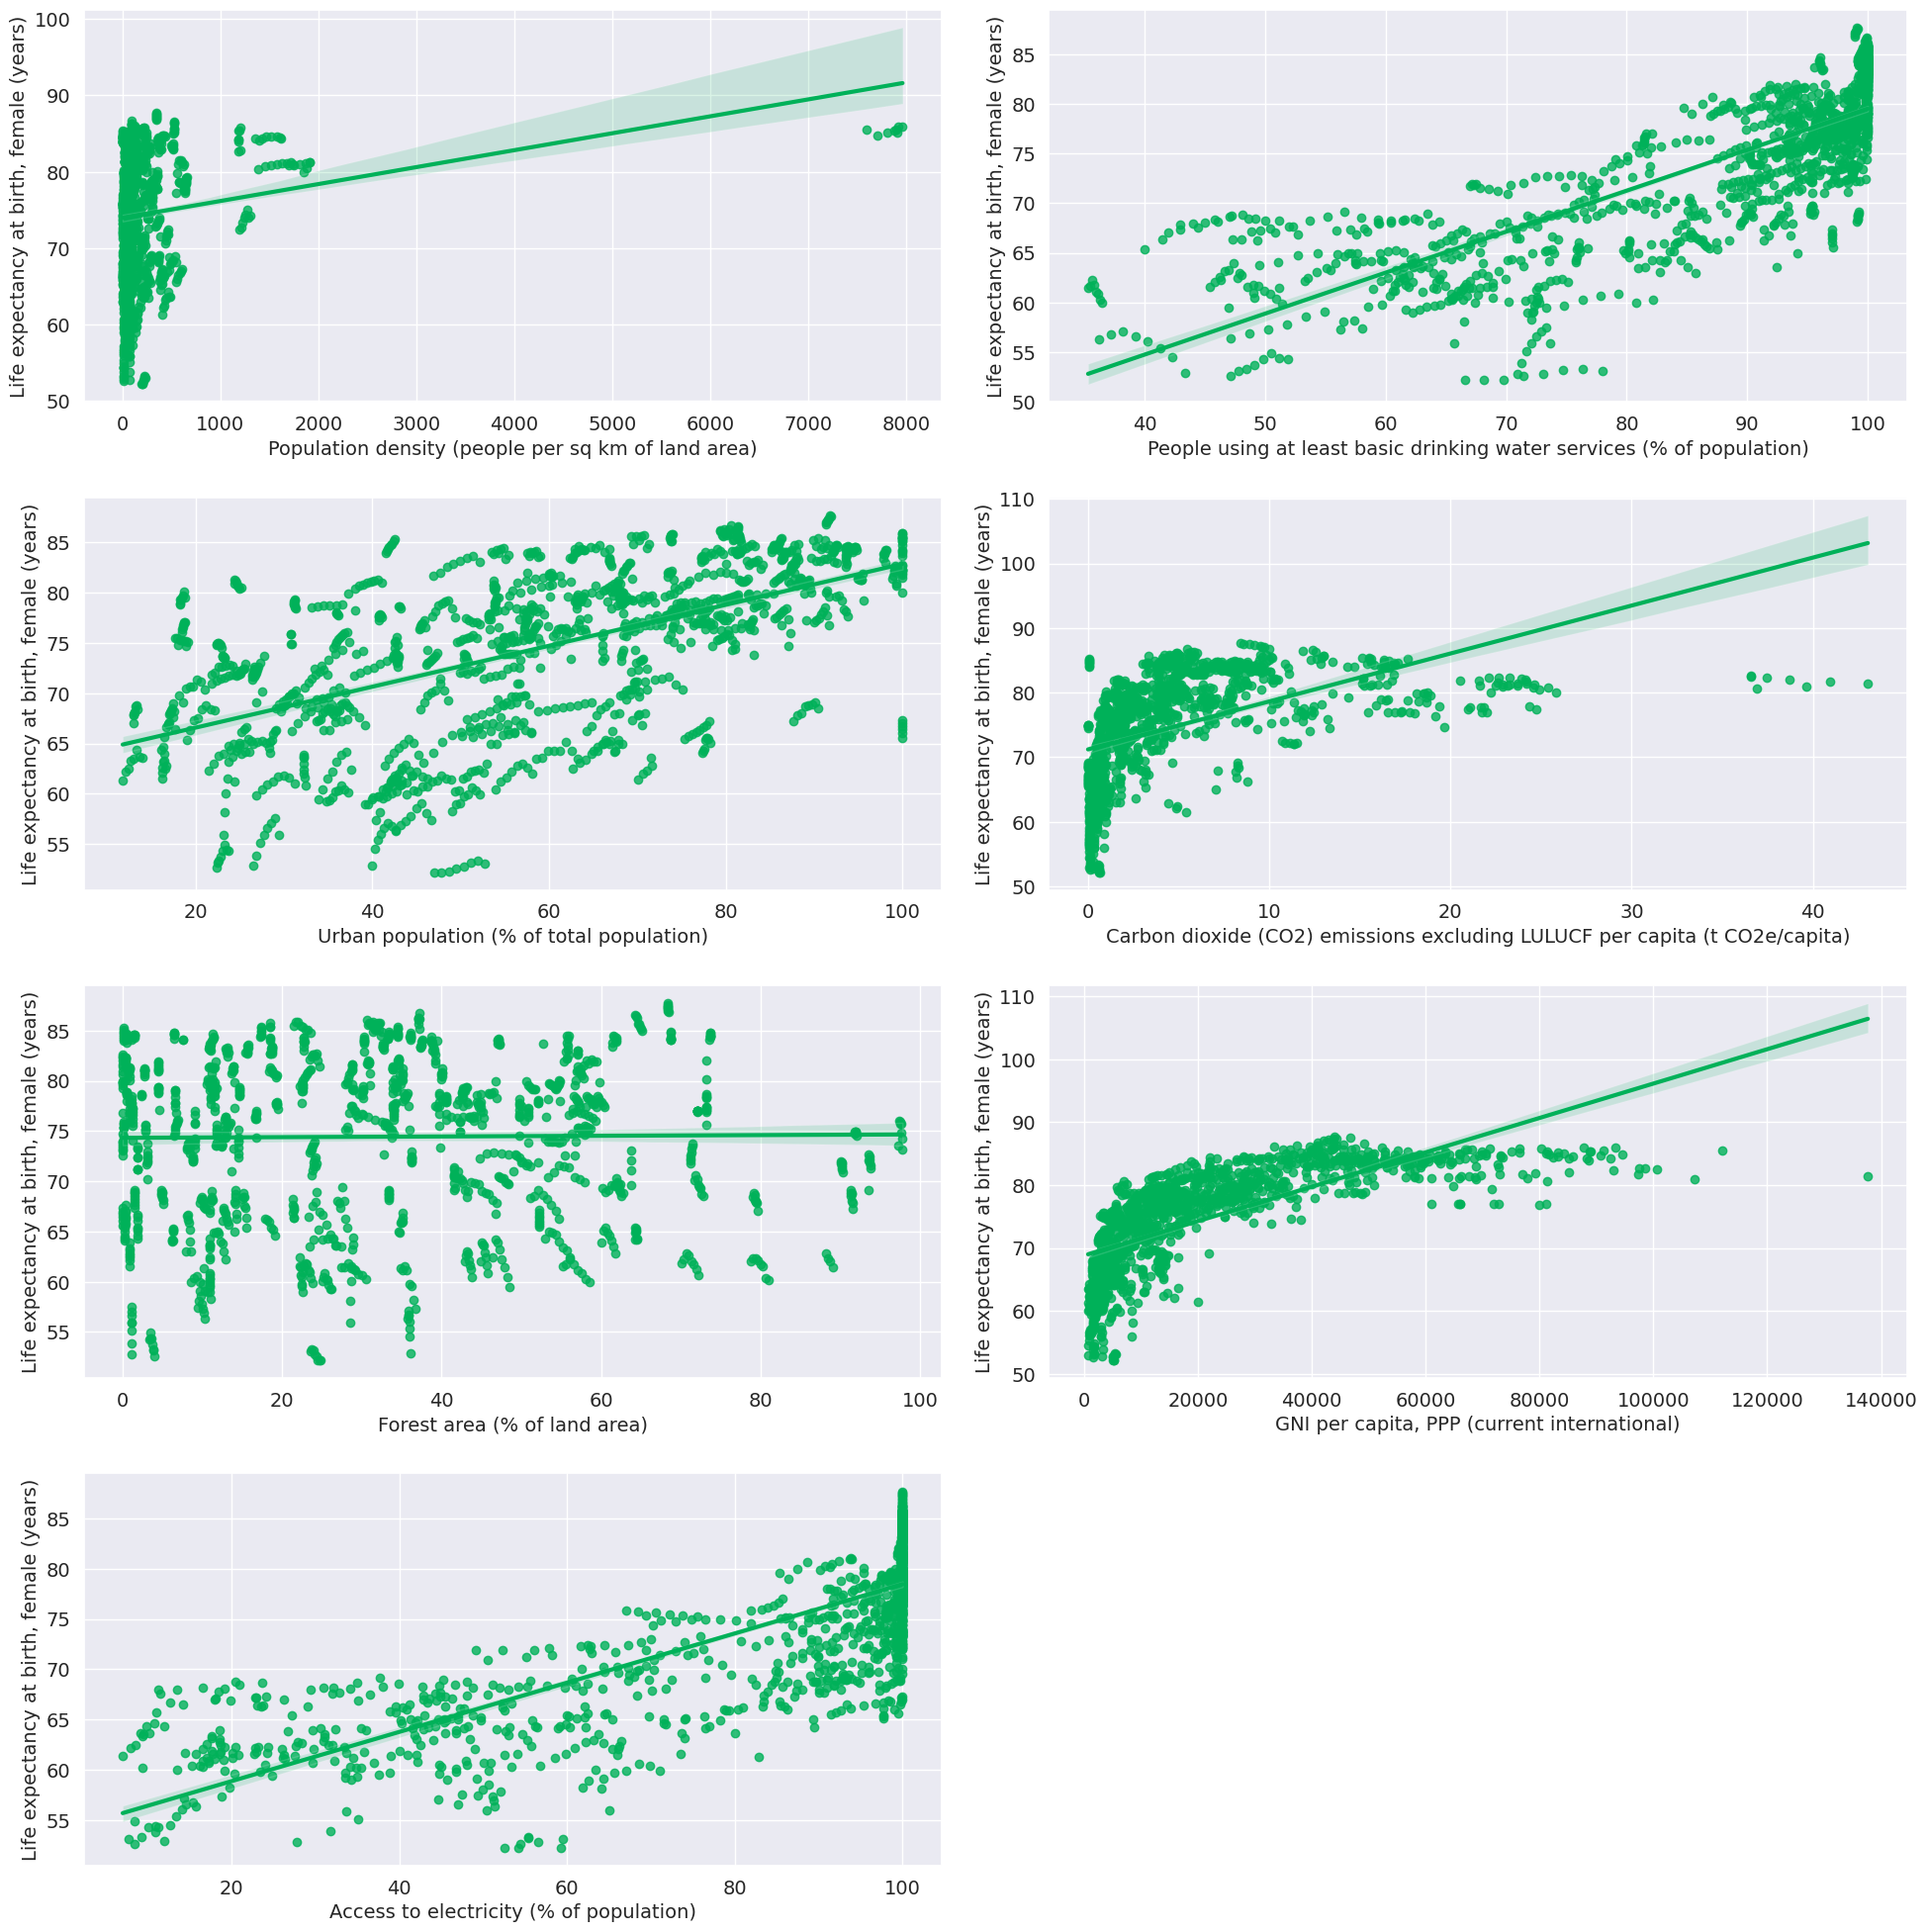

In [ ]:
# Plot the relationship between each continuous feature (i.e., independent variable) with the target (i.e., dependent) variable
sns.set_context("notebook", rc={"lines.linewidth": 2,
                                "xtick.labelsize":14,
                                "ytick.labelsize":14,
                                "axes.labelsize": 14
                                })

fig, axes = plt.subplots(4, 2, figsize=(20,20))
axes = axes.flatten()
fig.delaxes(axes[7])
columns = ['Population density (people per sq km of land area)',
       'People using at least basic drinking water services (% of population)',
       'Urban population (% of total population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Forest area (% of land area)',
       'GNI per capita, PPP (current international)',
       'Access to electricity (% of population)',
        'Life expectancy at birth, female (years)']

for i,feature in enumerate(columns):
  # print(i,feature)
  ax = sns.regplot(data=sdg_pdf,
                  x=feature,
                  y="Life expectancy at birth, female (years)",
                  color="#00b159",
                  ax=axes[i]
  )
fig.tight_layout(pad=2.0)


**Observation:**

*   Access to basic drinking water, electricity access, urbanization level, and income per capita all show a positive correlation with female life expectancy. This means that as these factors increase, female life expectancy tends to increase as well.
*   CO2 emissions per capita also have a positive correlation with life expectancy, likely due to its link with economic development.
*   Forest area and population density do not show a clear impact on female life expectancy.

In summary, economic development and improvements in infrastructure appear to have a strong influence on increasing female life expectancy.


# **Boxplot of Features**

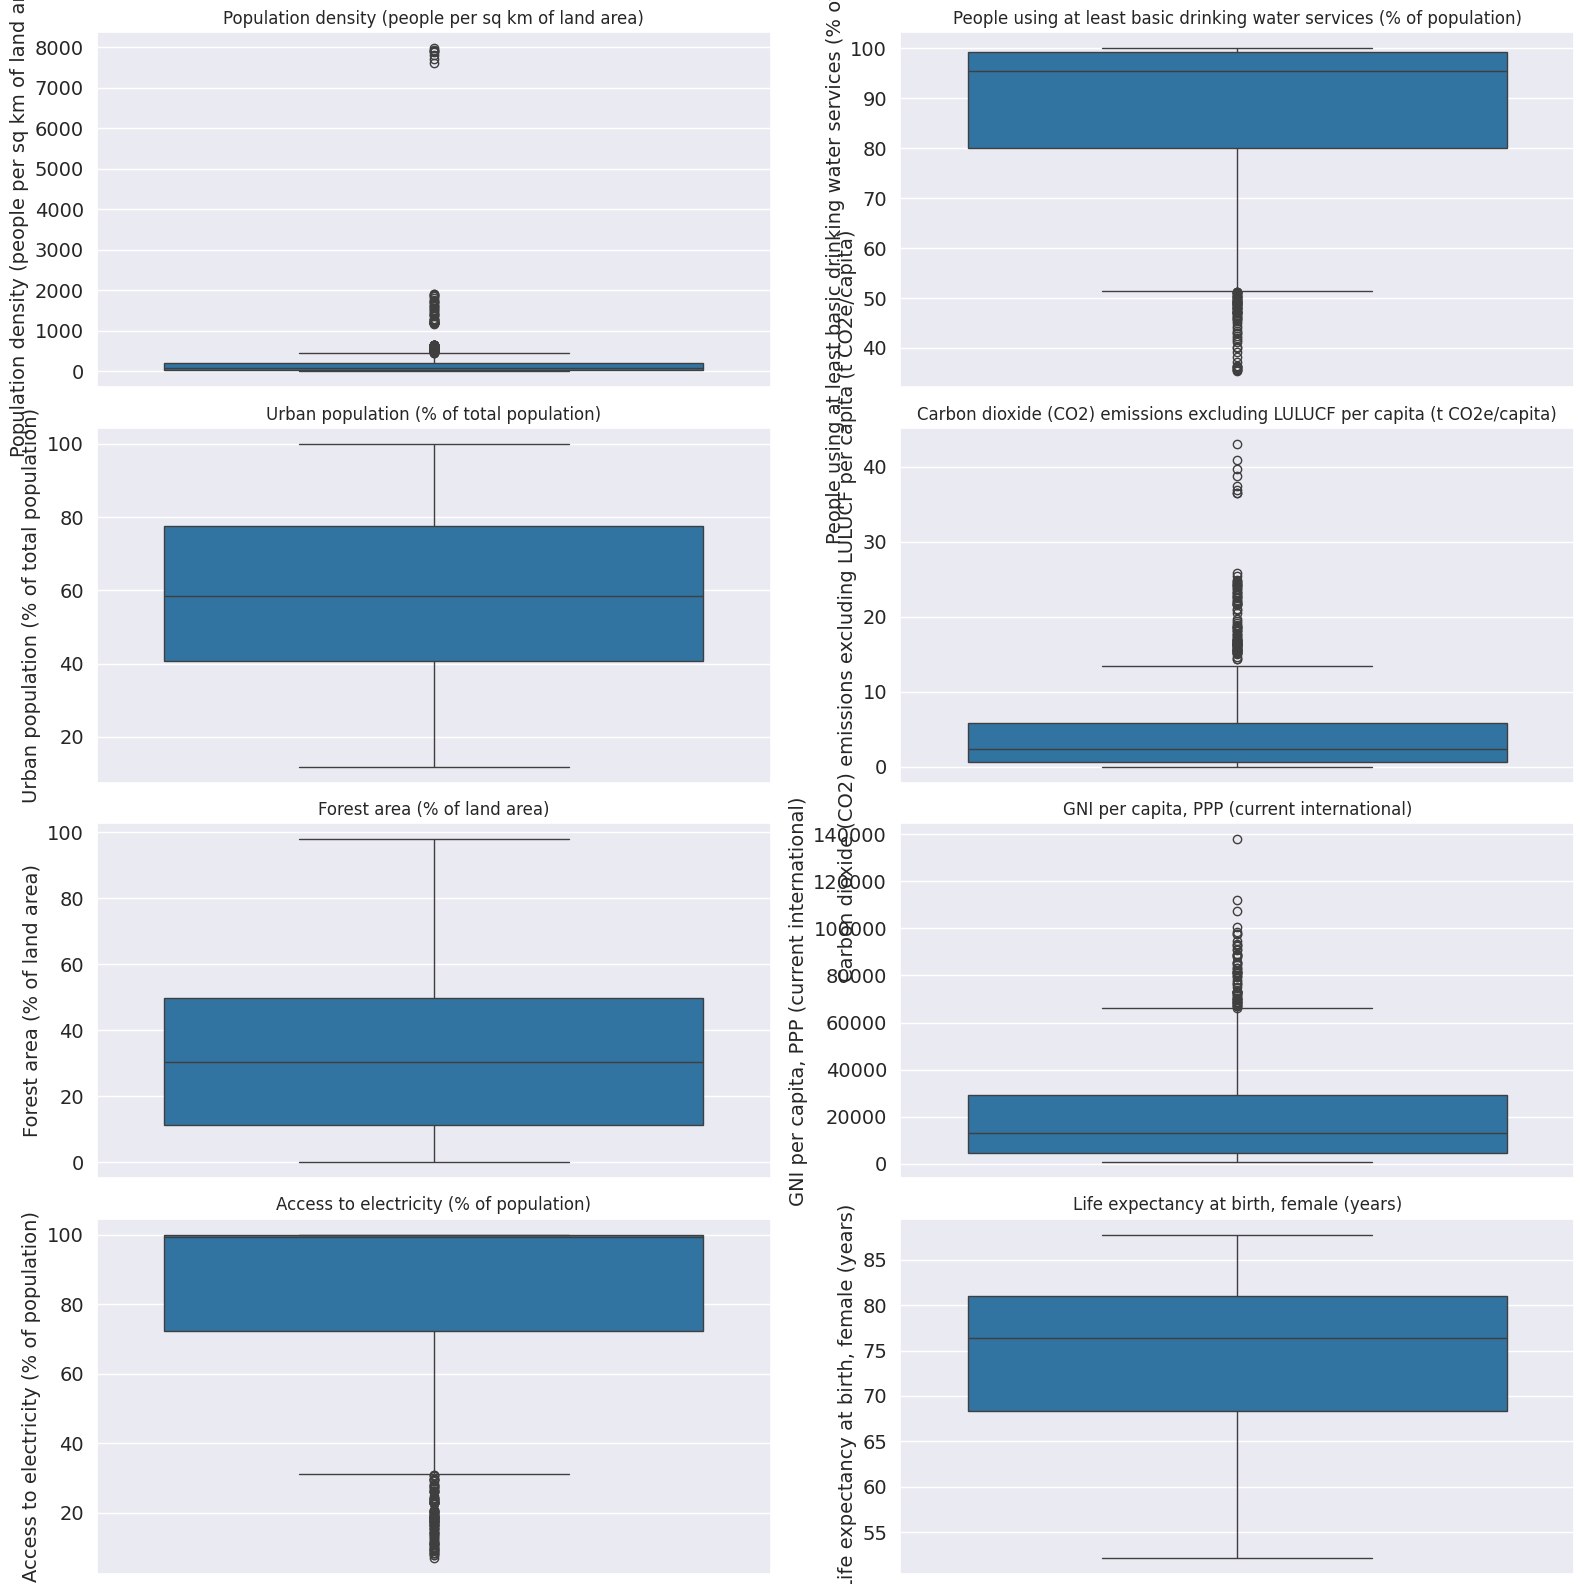

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(16,16))
axes = axes.flatten()

for i,feature in enumerate(columns):
  sns.boxplot(sdg_pdf[feature],ax=axes[i]
  )
  axes[i].set_title(f'{feature}')
  fig.tight_layout()


# **Conclusion:**
*  There are significant outliers in both population density and per capita carbon dioxide emissions. In particular, population density is widely distributed at higher values, indicating that a few areas have extremely high population density, while most areas have low population density.

*  The median values ​​for the two indicators of access to basic drinking water services and electricity access are close to 100%, indicating that in most areas these two services are widely available, but that there are still a few areas that lack these infrastructures.

The proportion of urban population and forest coverage are relatively evenly distributed, and the degree of urbanization and forest coverage vary significantly in different regions, reflecting the development levels and geographical diversity of different countries and regions.

The box plot of gross national income (GNI) per capita also shows a lot of outliers, and their distribution range is large, indicating that there is a large gap between countries in terms of income levels. Some countries have very high incomes, while most countries have low GNI. Low.

The distribution of female life expectancy at birth is relatively concentrated, with female life expectancy in most areas ranging from 60 to 85 years old, indicating that most areas have relatively similar health levels, but there are still some areas where life expectancy is lower.

**Pearson Correlation Coefficient and Correlation Matrix**


*   Too many features might cause overfitting. Thus, if a feature does not improve our model performance a lot, removing it may indeed be a better choice.
*   Very high correlation between a subset of features is also likely to cause overfitting. The correlation between the highly-correlated features does not provide much improvement in the model's peformance as each feature can be easily derived from the other.
*   Contrastingly, there are cases where these features might capture different aspects of the domain objects and thus improve the model's performance








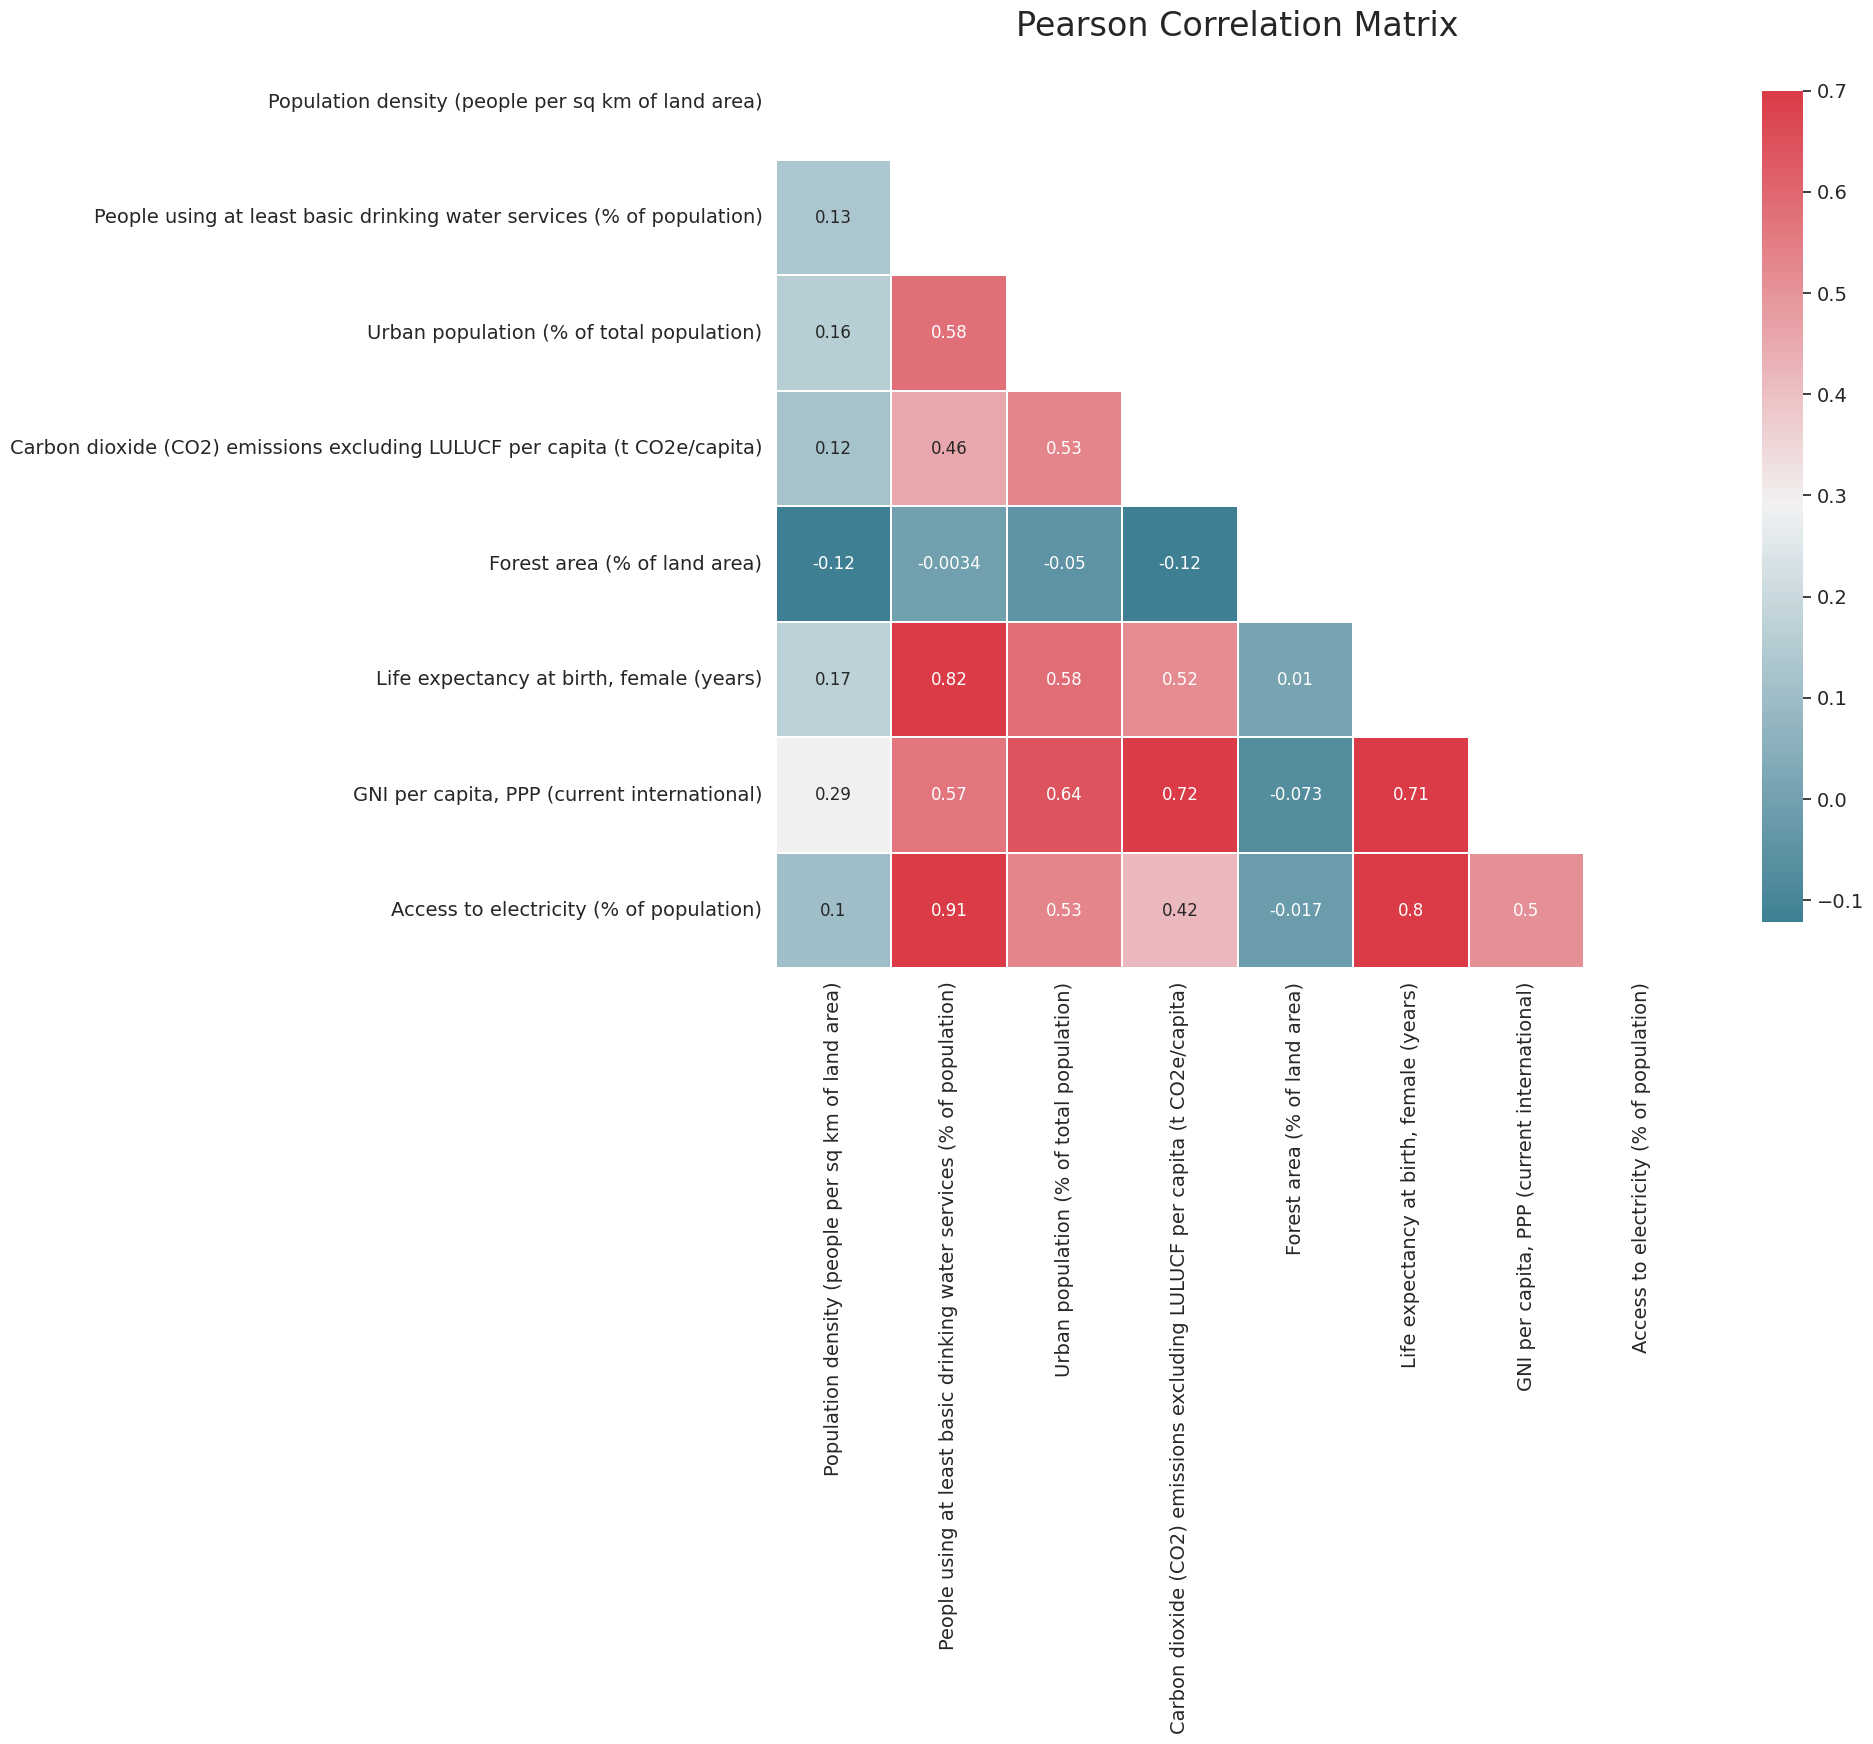

In [ ]:
import numpy as np

#calculate correlation matrix.
#np.zeros_like() creates a new array of the same shape as the correlation matrix, but filled with zeros.
mask = np.zeros_like(sdg_pdf.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True  #mask that covers upper triangular part

with sns.axes_style("white"): # Temporarily set the background to white
  fig, ax = plt.subplots(figsize=(16, 12))
  plt.title('Pearson Correlation Matrix', fontsize=24)

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  _ = sns.heatmap(sdg_pdf.corr(),
              linewidths=0.25,
              vmax=0.7,
              square=True,
              ax=ax,
              cmap=cmap,
              linecolor='w',
              annot=True,
              annot_kws={"size":12},
              mask=mask,
              cbar_kws={"shrink": .9});

# **Observations**


*   Access to electricity and people using atleast basic drinking water are high-positively correlated with each other (ρ=0.91);
*   GNI per capita, PPP and CO2 emissions are also highly correlated with a coefficient;
*   Access to electricity has the highest correlation with the target variable;



# **4.Experimenting with Random Forest Model**

**Random Dataset Splitting: Training and Test Set**
*   training set = 90% of dataset
*   test set 10% of dataset

In [ ]:
train_df, test_df = sdg_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

**Random Forest Pipeline**
*   Implement VectorAssembler and Random Forest Regressor in a pipeline;
*   Use 5-fold CV to find the best hyperparameters in paramGrid;

In [ ]:
def rf_regressor_pipeline(train,
                      k_fold=5):

    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import VectorAssembler

    assembler = VectorAssembler(inputCols=columns[:-1], #index 0 is target
                                outputCol="features")

    train = train.withColumnRenamed("Life expectancy at birth, female (years)", "label")
    rf = RandomForestRegressor(featuresCol='features',labelCol='label')

    pipeline = Pipeline(stages= [assembler] + [rf])

    param_grid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [5, 7, 12,20,25,30]) \
    .addGrid(rf.maxDepth, [3,5,7,11])\
    .build()

    cross_val = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               )
    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model


In [ ]:
rf_cv_model = rf_regressor_pipeline(train_df)

**Best parameters**

In [ ]:
best_params = rf_cv_model.bestModel.stages[-1].extractParamMap()

print("Best Parameters:")
for param, value in best_params.items():
    print(param.name, ": ", value)

Best Parameters:
bootstrap :  True
cacheNodeIds :  False
checkpointInterval :  10
featureSubsetStrategy :  auto
featuresCol :  features
impurity :  variance
labelCol :  label
leafCol :  
maxBins :  32
maxDepth :  11
maxMemoryInMB :  256
minInfoGain :  0.0
minInstancesPerNode :  1
minWeightFractionPerNode :  0.0
numTrees :  25
predictionCol :  prediction
seed :  2660134607880566964
subsamplingRate :  1.0


# **Measuring performance on the Training Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

Define metrics to evaluate model

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

def model_evaluate(predictions,metric):
  evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName=metric)
  return evaluator.evaluate(predictions)

def r2_adj(predictions):

    r2 = model_evaluate(predictions, metric="r2")
    r2_adj_score = (1 - (1 - r2) * ((predictions.count() - 1) / (predictions.count() - predictions.select('features').first()[0].size - 1)))

    return r2_adj_score

In [ ]:
train_df = test_df.withColumnRenamed("Life expectancy at birth, female (years)","label")
train_predictions = rf_cv_model.transform(train_df).select("features", "prediction", "label")

rmse =model_evaluate(train_predictions,"rmse")
r2 =model_evaluate(train_predictions,"r2")
r2_adj_score = r2_adj(train_predictions)

print("***** Training Set *****")
print("RMSE:"+str(rmse))
print("R2: "+str(r2))
print("Adjusted R2: "+str(r2_adj_score))

***** Training Set *****
RMSE:1.0635034311821139
R2: 0.9818466246426674
Adjusted R2: 0.9807018171877004


# **Measuring performance on the Test Set:  RMSE  and  R2  statistic**

In [ ]:
test_df = test_df.withColumnRenamed("Life expectancy at birth, female (years)","label")
predictions = rf_cv_model.transform(test_df)
predictions.select("features", "prediction", "label").show(5)

+--------------------+-----------------+------+
|            features|       prediction| label|
+--------------------+-----------------+------+
|[2.11513352394104...|75.90571432139755| 77.02|
|[2.72443604469299...| 65.5855867198157|63.049|
|[3.82867956161499...|65.36914119795556|66.276|
|[3.95222902297973...| 84.0513022005481| 83.91|
|[4.47751426696777...|65.18680725587376|66.098|
+--------------------+-----------------+------+
only showing top 5 rows



In [ ]:
rmse =model_evaluate(predictions,"rmse")
r2 =model_evaluate(predictions,"r2")
r2_adj_score = r2_adj(predictions)

print("***** Random Forest Regressor Test Set *****")
print(f"RMSE: {rmse:.3f}")
print(f"R2: "+str(r2))
print(f"Adjusted R2: "+str(r2_adj_score))

***** Random Forest Regressor Test Set *****
RMSE: 1.064
R2: 0.9818466246426674
Adjusted R2: 0.9807018171877004


# **5. Model Parameter Analysis**

##Display Feature Importances

Feature importance dictates the influence of each feature in the prediction of the target variable


###Feature Importance for Random Forest Regressor

Feature Importances for RF regressor:
-----------------------------------------------------
Urban population (% of total population): 0.4249
Access to electricity (% of population): 0.2576
GNI per capita, PPP (current international): 0.1427
Forest area (% of land area): 0.0644
Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita): 0.0401
People using at least basic drinking water services (% of population): 0.0370
label: 0.0333


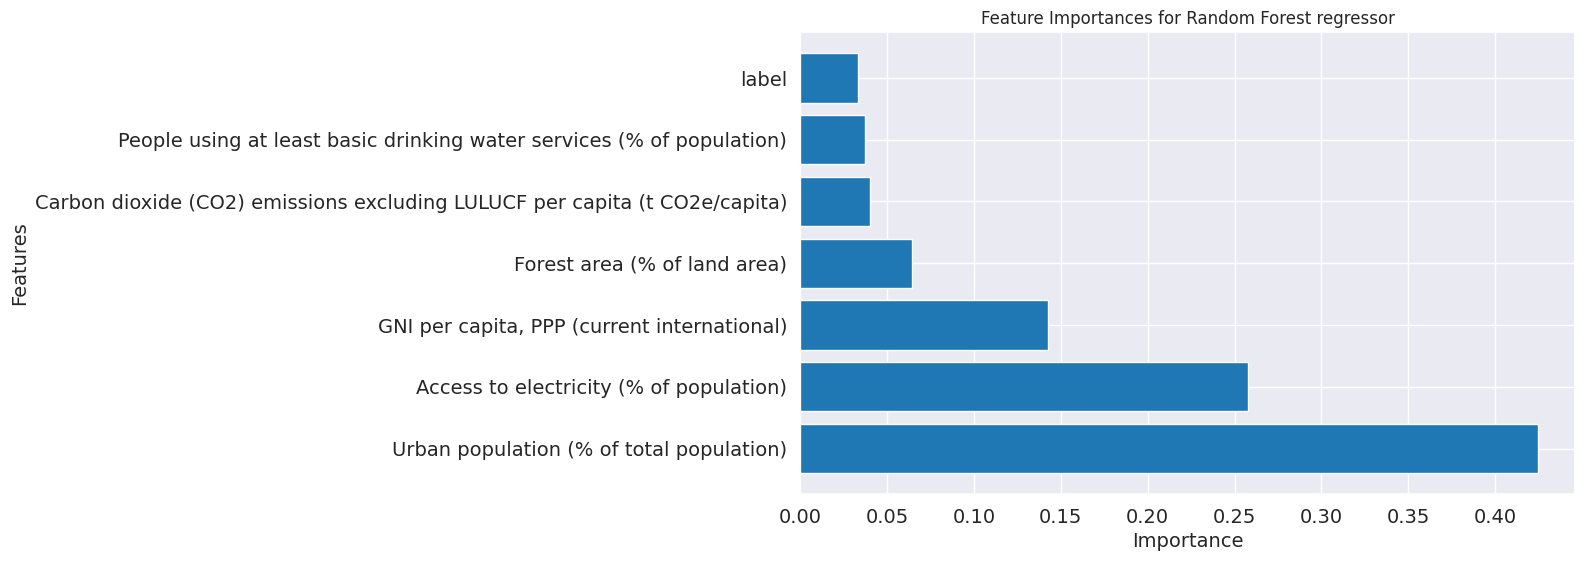

In [ ]:
best_rf_model = rf_cv_model.bestModel.stages[-1]
importances = best_rf_model.featureImportances
feature_list =train_df.columns[1:]

feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances in descending order based on importance values
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
print("Feature Importances for RF regressor:")
print("-----------------------------------------------------")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.4f}")

features = [feature for feature, _ in sorted_feature_importances]
importances = [importance for _, importance in sorted_feature_importances]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances for Random Forest regressor')
plt.show()

###**Observations**
*  The random forest regressor calculates feature importances based on the overall predictive influence of each feature.
*  It considers interactions and also the mapping of nonlinear relationships between features and the target variable.
*  The feature importances for the random forest regressor are all positive in this instance, indicating that these features have a positive impact on the target variable (Female's Life Expectancy).
*  This suggests that the random forest regressor considers all the features as important contributors to the prediction (each feature has is modelled with a different importance which is learned through training).


##**Best Parameters**

###Best Parameters of Random Forest Regressor

* The best parameters for the Random Forest Regressor were obtained from the grid search using cross-validation and 'RMSE' metric.
* The grid was composed of 2 paramters :
  * `numTress` parameter which determines the number of decision trees, that are combined to create the final prediction. Increasing the number of trees can enhance the model's ability to capture complex relationships and improve its overall performance.
  * `maxDepth` parameter which determines the number of splits that each decision tree is allowed to make. A higher maxDepth allows the trees to have more splits and potentially capture more intricate patterns in the data.


* `numTrees` = 7 and `maxDepth` = 7 were the combination of parameters that performed best on evaluation metric used in the cross-validation process (RMSE).

For the random forest regression model, feature importance indicates the relative significance of each feature in predicting the `Female's Life Expectancy`. The higher the feature importance value, the more influential the corresponding feature is in determining the Life Expectancy. As seen above, the following features, based on the trained random forest model with the best parameter values (numTrees = 7, maxDepth = 7), were found to have relatively higher importance:
  * `urban population (% of total population) `- This feature has the one of the highest weights. It suggests that urban population has a significant positive impact on Female's Life Expectancy. Countries with a higher percentage of the urban population tend to have higher life expectancies.
  * `Access to electricity (% of population))` - The importance of this feature suggests that the access to electricity in the population has a significant impact on Female's Life Expectancy.
  * `GIN per capita,PPP ` - With an importance of 0.1427, this feature suggests that GIN percapital positively impacts Female's Life Expectancy. Countries with a higher average income level tend to have higher life expectancies.

**These features are considered to have a stronger impact on Female Life Expectancy according to the random forest regression model.**

In [ ]:
best_params = rf_cv_model.bestModel.stages[-1].extractParamMap()

print("Best Parameters:")
for param, value in best_params.items():
    print(param.name, ": ", value)

Best Parameters:
bootstrap :  True
cacheNodeIds :  False
checkpointInterval :  10
featureSubsetStrategy :  auto
featuresCol :  features
impurity :  variance
labelCol :  label
leafCol :  
maxBins :  32
maxDepth :  11
maxMemoryInMB :  256
minInfoGain :  0.0
minInstancesPerNode :  1
minWeightFractionPerNode :  0.0
numTrees :  25
predictionCol :  prediction
seed :  2660134607880566964
subsamplingRate :  1.0


# **6. Conclusion**

The Random Forest Regressor demonstrated the best predictive performance on the test set, achieving an RMSE of 1.064 and an Adjusted R2 of 0.980. These high values indicate that the model is able to predict Female's life expectancy using SGD indicators with a high degree of accuracy.

Analysing the feature importances, the Random Forest Regressor highlighted `urban population `, `Access to electricity`, and `GIN per capita,PPP` as the most influential indicators.

The strengths of the Random Forest Regressor lie in its ability to handle complex relationships between features and the target variable, as well as its robustness against overfitting.

To improve the analysis, further exploration of the data and feature engineering techniques could be implemented. Additionally, considering other algorithms or ensemble methods may provide additional insights and enhance predictive accuracy.

Overall, this notebook demonstrates the potential of SDG indicators in predicting Female's Life Expectancy. Further investigations and refinements to the models could yield valuable insights for policymakers and researchers aiming to understand the factors influencing Female's Life Expectancy and guide interventions to improve global health outcomes.